# Apprentissage  des coefficients de la norme de Sobolev


1. **Approche initiale simple** :
   - Tentative d'apprentissage direct des coefficients.
   - Problème : Les coefficients prenaient des valeurs aberrantes.

2. **Utilisation de log et exp** :
   - Modification pour assurer la positivité des coefficients.
   - Résultat : Les valeurs des coefficients étaient proches de zéro.
   - Interprétation : Comportement attendu car le modèle cherche à minimiser la fonction de perte.

3. **Application de softmax** :
   - Ajout d'une contrainte pour que la somme des coefficients soit égale à 1.
   - Avantage : Normalisation des coefficients et maintien de leur importance relative.

## Gradient Reversal

L'idée du Gradient Reversal est une approche  pour gérer l'apprentissage des coefficients :

1. **Principe** : Inverser le gradient lors de la rétropropagation pour les coefficients.

2. **Implémentation** :
   - Utilisation d'une couche `GradientReversal` personnalisée.
   - Cette couche laisse passer les données inchangées lors de la passe avant.
   - Lors de la rétropropagation, elle multiplie le gradient par -1 et par un facteur α.

3. **Objectif** :
   - Créer un "adversaire" qui tente de maximiser la perte alors que le reste du modèle tente de la minimiser.
   - Cela force le modèle à trouver des coefficients robustes qui fonctionnent bien même dans des conditions défavorables.






# Analyse des résultats

L'entraînement du modèle FNO avec l'approche adversariale a montré des résultats intéressants. Notamment, l'évolution des poids adversariaux a convergé vers une répartition quasi-égale (environ 0,52 et 0,48) au fil des époques. Cette convergence vers des poids équilibrés pourrait indiquer une limitation du modèle ou suggérer que les deux composantes de la perte sont également importantes pour l'optimisation.

En ce qui concerne les performances, l'analyse des courbes de corrélation révèle des informations cruciales. Les deux modèles, adversarial et séquence, maintiennent une corrélation supérieure à 80% jusqu'à environ 500 pas de temps, ce qui indique une bonne précision à court et moyen terme. Cependant, le modèle adversarial semble conserver une légère avance, particulièrement visible dans la région de 250 à 500 pas de temps.

Il est important de noter que ces résultats sont basés sur 10 échantillons différents, ce qui offre une vue plus approfondie et robuste des performances comparatives. Bien que les courbes des deux modèles soient proches pour certains échantillons, le modèle adversarial démontre une meilleure généralisation globale. Cela est particulièrement évident dans la courbe de corrélation moyenne, où le modèle adversarial maintient systématiquement une corrélation plus élevée sur l'ensemble de la trajectoire temporelle.

Cette supériorité en termes de généralisation pourrait être attribuée à la technique d'entraînement adversarial, qui semble permettre au modèle de capturer plus efficacement les dynamiques complexes de l'équation de Kuramoto sur des horizons temporels plus longs.




Le modèle FNO adversarial entraîné a été sauvegardé dans le fichier :

```
best_fno_model_adversarial.pth
```



In [1]:
import os
import sys
import random
from typing import Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, ifftn, fftfreq
from scipy.fftpack import diff as psdiff
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%matplotlib inline


cuda


In [2]:
class SkipConnection(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SkipConnection, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class SpectralConv1d(nn.Module):
  def __init__(self, in_channels, out_channels,modes):
    """
    modes : number of fourier modes kept
    """
    super(SpectralConv1d, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.modes = modes
    self.scale = (1 / (in_channels*out_channels))

    self.weights = nn.Parameter(self.scale * torch.rand(self.in_channels, self.out_channels, self.modes, dtype=torch.cfloat))

  def complex_mult1d(self, input, w):
    return torch.einsum('bix,iox->box',input,w)

  def forward(self, x):
    #compute the fourier coefficients
    x_ft = torch.fft.rfft(x)
    # Use only relevant fourier modes
    # need to perform some slicing to select only the relevant parts
    #The real-to-complex FFT reduces the last dimension (Nx) to Nx//2 + 1
    #due to the symmetry in the Fourier transform of real-valued signals.

    out = torch.zeros(x.shape[0],self.out_channels,x.size(-1)//2+1,dtype=torch.cfloat).to(x.device)

    out[:,:,:self.modes] = self.complex_mult1d(x_ft[:,:,:self.modes],self.weights)
    out = torch.fft.irfft(out,n=x.size(-1))
    return out



In [3]:
class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv1d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv1d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x


class FNO1d(nn.Module):
  def __init__(self,modes,width,input_channels,output_channels):

    """
    The newtork consists of 4 Fourier Layers
    ->First we need to lift the input to the desired channel dim
    ->Then we apply the Fourier Layers
    ->Finally we need to project  the output back to the desired output space
    """
    super(FNO1d,self).__init__()

    self.modes = modes
    self.width = width
    self.input_channels = input_channels
    self.output_channels = output_channels
    #the output tensor from this layer will have a size of self.width
    #For now we will use a linear transformation
    self.lifting1 = nn.Conv1d(input_channels,self.width//2,1)
    self.lifting2 = nn.Conv1d(self.width//2,self.width,1)


    #define the Fourier Layers
    self.conv0 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv1 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv2 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv3 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv4 = SpectralConv1d(self.width,self.width,self.modes)
    #self.conv5 = SpectralConv1d(self.width,self.width,self.modes)

    #We still need to add the second half of the fourier layer which consists of

    #Mutliplying the input by a weight matrix and optionally adding a bias
    #We can either use conv1D or an MLP

    #Conv1d capture local features well but could miss out on capturing long-range
    #dependencies and complex nonlinear interactions that span the entire input space.

    ##MLP capture global interactions and complex relationships but might be less
    ## efficient and miss out on local detail refinements.

    ###In practice combining them both gives the best results
    self.w0 = nn.Conv1d(self.width, self.width, 1)
    self.w1 = nn.Conv1d(self.width, self.width,1)
    self.w2 = nn.Conv1d(self.width, self.width, 1)
    self.w3 = nn.Conv1d(self.width, self.width, 1)
    self.w4 = nn.Conv1d(self.width,self.width,1)
    #self.w5 = nn.Conv1d(self.width,self.width,1)

   

    #two layers to introduce non linearity
    self.projection1 = nn.Conv1d(self.width,self.width*2,1)
    self.projection2 = nn.Conv1d(self.width*2,output_channels,1)
    

  def forward(self,x):
      #First step : lift
      x = x.permute(0,2,1)
      x = self.lifting1(x)
      x = F.gelu(x)


      x = self.lifting2(x)
      x = F.gelu(x)
      # we need to permute because the next layer  expect the input to have the channels dimension second
      #x = x.permute(0,2,1)
      
      #2nd step : Fourier Layers
      x_skip = x
      x_0 = self.conv0(x)
      x_1 = self.w0(x)

      x = x_0 + x_1 
      x = F.elu(x) + x_skip

      #x_skip = x
      x_0 = self.conv1(x)
      x_1 = self.w1(x)
      x = x_0 + x_1 
      x = F.elu(x) + x_skip

      #x_skip = x
      x_0 = self.conv2(x)
      x_1 = self.w2(x)
      x = x_0 + x_1 
      x = F.elu(x) + x_skip

      x_skip = x
      x_0 = self.conv3(x)
      x_1 = self.w3(x)
      x = x_0 + x_1 
      x = F.elu(x) + x_skip
      
      x_skip = x
      x_0 = self.conv3(x)
      x_1 = self.w3(x)
      x = x_0 + x_1 + x_skip
      

      #3rd step : projection
      #x = x.permute(0,2,1)
      x = self.projection1(x)
      x = F.gelu(x)
      x = self.projection2(x)
      if self.output_channels == 1:
        x = x.permute(0,2,1)

      return x





In [6]:

def sample_uniformly(inputs: np.ndarray, outputs: np.ndarray, num_samples: int) -> Tuple[np.ndarray, np.ndarray]:
    total_samples = inputs.shape[0]
    sampled_indices = random.sample(range(total_samples), num_samples)
    sampled_inputs = inputs[sampled_indices]
    sampled_outputs = outputs[sampled_indices]
    return sampled_inputs, sampled_outputs

def load_dataset(output_dir, dataset_type):
    inputs = np.load(os.path.join(output_dir, f'{dataset_type}_inputs.npy'))
    outputs = np.load(os.path.join(output_dir, f'{dataset_type}_outputs.npy'))
    return inputs, outputs

def create_1_to_n_pairs(inputs, outputs, n):
    new_inputs = []
    new_outputs = []
    
    num_samples = inputs.shape[0]
    
    for i in range(num_samples - n + 1):
        new_inputs.append(inputs[i])
        new_outputs.append(outputs[i:i+n])
    
    new_inputs = np.array(new_inputs)
    new_outputs = np.array(new_outputs)
    
    return new_inputs, new_outputs


output_dir = './ks_data'

# Load the datasets
print("Loading datasets...")
train_inputs = np.load(os.path.join(output_dir, 'train_inputs.npy'))
train_outputs = np.load(os.path.join(output_dir, 'train_outputs.npy'))
val_inputs = np.load(os.path.join(output_dir, 'val_inputs.npy'))
val_outputs = np.load(os.path.join(output_dir, 'val_outputs.npy'))

# Convert numpy arrays to PyTorch tensors
print("Converting numpy arrays to PyTorch tensors...")
train_inputs_tensor = torch.tensor(train_inputs, dtype=torch.float32)
train_outputs_tensor = torch.tensor(train_outputs, dtype=torch.float32)
val_inputs_tensor = torch.tensor(val_inputs, dtype=torch.float32)
val_outputs_tensor = torch.tensor(val_outputs, dtype=torch.float32)

# Parameters
n = 20  # Number of successive steps


# Ensure correct dimensions and types
print(f"Train inputs shape: {train_inputs.shape}")
print(f"Train outputs shape: {train_outputs.shape}")
print(f"Validation inputs shape: {val_inputs.shape}")
print(f"Validation outputs shape: {val_outputs.shape}")


# Create 1-to-n pairs for the training set
train_inputs, train_outputs = create_1_to_n_pairs(train_inputs, train_outputs, n)
print(f"Created {train_inputs.shape[0]} 1-to-{n} pairs for training set.")

# Create 1-to-n pairs for the validation set
val_inputs, val_outputs = create_1_to_n_pairs(val_inputs, val_outputs, n)
print(f"Created {val_inputs.shape[0]} 1-to-{n} pairs for validation set.")


# Verify the new shapes
print(f"New train inputs shape: {train_inputs.shape}")
print(f"New train outputs shape: {train_outputs.shape}")
print(f"New val inputs shape: {val_inputs.shape}")
print(f"New val outputs shape: {val_outputs.shape}")



Loading datasets...
Converting numpy arrays to PyTorch tensors...
Train inputs shape: (240000, 256, 2)
Train outputs shape: (240000, 256)
Validation inputs shape: (20000, 256, 2)
Validation outputs shape: (20000, 256)
Created 239981 1-to-20 pairs for training set.
Created 19981 1-to-20 pairs for validation set.
New train inputs shape: (239981, 256, 2)
New train outputs shape: (239981, 20, 256)
New val inputs shape: (19981, 256, 2)
New val outputs shape: (19981, 20, 256)


In [7]:

num_samples_train = 50000
num_samples_val = 3000

# Uniformly sample 10,000 pairs from the training set
sampled_train_inputs, sampled_train_outputs = sample_uniformly(train_inputs, train_outputs, num_samples_train)


sampled_inputs_val, sampled_outputs_val = sample_uniformly(val_inputs, val_outputs, num_samples_val)


# Convert numpy arrays to PyTorch tensors
print("Converting numpy arrays to PyTorch tensors...")
sampled_train_inputs_tensor = torch.tensor(sampled_train_inputs, dtype=torch.float32)
sampled_train_outputs_tensor = torch.tensor(sampled_train_outputs, dtype=torch.float32)
sampled_val_inputs_tensor = torch.tensor(sampled_inputs_val, dtype=torch.float32)
sampled_val_outputs_tensor = torch.tensor(sampled_outputs_val, dtype=torch.float32)

# Create TensorDatasets
print("Creating TensorDatasets...")
train_dataset = TensorDataset(sampled_train_inputs_tensor, sampled_train_outputs_tensor)
val_dataset = TensorDataset(sampled_val_inputs_tensor, sampled_val_outputs_tensor)


# Create DataLoaders
batch_size = 50
print("Creating DataLoaders...")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(sampled_train_inputs_tensor.shape)
print(sampled_train_outputs_tensor.shape)


Converting numpy arrays to PyTorch tensors...
Creating TensorDatasets...
Creating DataLoaders...
torch.Size([50000, 256, 2])
torch.Size([50000, 20, 256])


# Évolution de l'implémentation de la norme de Sobolev comme fonction de perte

---

## 1. SobolevLossFourier

> Implémentation de base

- Norme de Sobolev dans l'espace de Fourier
- Poids fixes basés sur les fréquences

---

## 2. CombinedLoss

> Combinaison de pertes

- Fusion de la perte de Sobolev avec une perte MSE classique
- Introduction de poids d'équilibrage

---

## 3. AdaptiveSobolevLossFourier

> Évolution vers l'adaptativité

- Poids adaptatifs pour la norme de Sobolev
- Paramètres apprenables (log_weights)
- Mécanismes pour :
  * Assurer la positivité des poids
  * Normaliser les poids

---

## 4. AdversarialSobolevLossReversal

> Approche avancée avec Gradient Reversal

- Introduction d'un "adversaire" (WeightAdversary)
- Utilisation de GradientReversal
- Contrôle supplémentaire :
  * Terme d'entropie
  * Régularisation L2




In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch
import torch.nn as nn
import torch
import torch.nn as nn

class SobolevLossFourier(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, k=2):
        super(SobolevLossFourier, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.k = k

    def frequency_weights(self, nx):
        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),
                         torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(1, nx)
        k_x = torch.abs(k_x)
        weights = torch.ones_like(k_x, dtype=torch.float32)
        for i in range(1, self.k + 1):
            weights += k_x**(2 * i)
        return weights.unsqueeze(1)  # Shape: (1, 1, nx)

    def compute_loss(self, x, y):
        if x.dim() == 3:
            batch_size, nt, nx = x.shape
        else:
            batch_size, nx = x.shape
            nt = 1
            x = x.unsqueeze(1)
            y = y.unsqueeze(1)

        x_fft = torch.fft.fftn(x, dim=-1)
        y_fft = torch.fft.fftn(y, dim=-1)

        weights = self.frequency_weights(nx).to(x.device)
        weights = weights.repeat(1, nt, 1)  # Repeat for time dimension if necessary

        diff_fft = x_fft - y_fft
        h1_loss = torch.sum(weights * torch.abs(diff_fft)**2,)

        # Normalize by the energy of the target signal
      
        h1_loss = h1_loss / (torch.sum(weights * torch.abs(y_fft)**2) + 1e-8)

        return h1_loss.mean()

    def forward(self, pred, target):
        return self.compute_loss(pred, target)


class CombinedLoss(nn.Module):
    def __init__(self, sobolev_weight=1.0, mse_weight=0.1):
        super().__init__()
        self.sobolev_loss = SobolevLossFourier(alpha=1.0, beta=1.0, k=1)
        self.mse_loss = nn.MSELoss()
        self.sobolev_weight = sobolev_weight
        self.mse_weight = mse_weight

    def forward(self, pred, target):
        sobolev = self.sobolev_loss(pred, target)
        mse = self.mse_loss(pred, target)
        return self.sobolev_weight * sobolev + self.mse_weight * mse

class AdaptiveSobolevLossFourier(nn.Module):
    def __init__(self, k=1):
        super(AdaptiveSobolevLossFourier, self).__init__()
        self.k = k
        # Initialize learnable weights
        self.log_weights = nn.Parameter(torch.tensor([math.log(1/(i+1)) for i in range(k+1)]))


    def get_positive_weights(self):
        #return torch.exp(self.log_weights)  # Always positive
        return F.softmax(self.log_weights, dim=0)
    
    
    def get_normalized_weights(self):
        return F.softmax(self.log_weights, dim=0)

    def frequency_weights(self, nx):
        device = self.log_weights.device
        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),
                         torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(1, nx).to(device)
        k_x = torch.abs(k_x)
        k_x = k_x/nx
        weights = self.get_positive_weights()[0] * torch.ones_like(k_x, dtype=torch.float32)
        for i in range(1, self.k + 1):
            #weights += self.get_positive_weights()[i] * k_x**(2 * i)
            weights += self.get_positive_weights()[i] * torch.log(1 + k_x**(2 * i))
        return weights.unsqueeze(1)

    def compute_loss(self, x, y):
        if x.dim() == 3:
            batch_size, nt, nx = x.shape
        else:
            batch_size, nx = x.shape
            nt = 1
            x = x.unsqueeze(1)
            y = y.unsqueeze(1)

        x_fft = torch.fft.fftn(x, dim=-1)
        y_fft = torch.fft.fftn(y, dim=-1)

        weights = self.frequency_weights(nx).to(x.device)
        weights = weights.repeat(1, nt, 1)  # Repeat for time dimension if necessary

        diff_fft = x_fft - y_fft
        h1_loss = torch.sum(weights * torch.abs(diff_fft)**2)

        # Normalize by the energy of the target signal
        h1_loss = h1_loss / (torch.sum(weights * torch.abs(y_fft)**2) + 1e-8)

        return h1_loss.mean()

    def forward(self, pred, target):
        sobolev_loss = self.compute_loss(pred, target)
        mse_loss = F.mse_loss(pred, target)
        
        # Combine Sobolev loss and MSE loss
        combined_loss = sobolev_loss
        w = self.get_positive_weights()
        # Add L2 regularization on weights
        l2_reg = 1e-4 * torch.sum(w**2)
        
        return combined_loss + l2_reg

     
    def adjust_weights(self):
        with torch.no_grad():
            min_weight = self.get_positive_weights().min()
            if min_weight < 1e-3:
                self.weights.data += math.log(1e-3) - math.log(min_weight.item())

    def log_weights_and_grads(self):
        weights = self.get_positive_weights()
        print(f"Positive weights: {weights.detach().cpu().numpy()}")
        #print(f"Log weights: {self.log_weights.detach().cpu().numpy()}")
        #if self.log_weights.grad is not None:
        #    print(f"Log weights gradients: {self.log_weights.grad.detach().cpu().numpy()}")



#####Try gradient reversal

class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class WeightAdversary(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.weight_generator = nn.Sequential(
            nn.Linear(k+1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, k+1)
        )
    
    def forward(self, x, alpha):
        x = GradientReversal.apply(x, alpha)
        return F.softmax(self.weight_generator(x), dim=-1)

class AdversarialSobolevLossReversal(nn.Module):
    def __init__(self, k=2, eps=1e-8, alpha=1.0, temperature=1.0, entropy_weight=0.01, l2_weight=0.01):
        super().__init__()
        self.k = k
        self.eps = eps
        self.alpha = alpha
        self.temperature = temperature
        self.entropy_weight = entropy_weight
        self.l2_weight = l2_weight
        self.adversary = WeightAdversary(k)

    def get_weights(self):
        initial_weights = torch.rand(self.k+1).to(self.adversary.weight_generator[0].weight.device)
        raw_weights = self.adversary(initial_weights, self.alpha)
        weights = F.softmax(raw_weights / self.temperature, dim=-1)
        return weights
    
              
    def frequency_weights(self, nx, weights):
        device = weights.device
        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),
                         torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(1, nx).to(device)
        k_x = torch.abs(k_x)
        k_x = k_x / nx
        freq_weights = weights[0] * torch.ones_like(k_x, dtype=torch.float32)
        for i in range(1, self.k + 1):
            freq_weights += weights[i] * k_x**(2 * i)
        return freq_weights.unsqueeze(1)
    def compute_loss(self, x, y, weights):
        if x.dim() == 3:
            batch_size, nt, nx = x.shape
        else:
            batch_size, nx = x.shape
            nt = 1
            x = x.unsqueeze(1)
            y = y.unsqueeze(1)

        x_fft = torch.fft.fftn(x, dim=-1)
        y_fft = torch.fft.fftn(y, dim=-1)

        freq_weights = self.frequency_weights(nx, weights).to(x.device)
        freq_weights = freq_weights.repeat(1, nt, 1)

        diff_fft = x_fft - y_fft
        h1_loss = torch.sum(freq_weights * torch.abs(diff_fft)**2)

        # Normalize by the energy of the target signal
        h1_loss = h1_loss / (torch.sum(freq_weights * torch.abs(y_fft)**2) + self.eps)

        return h1_loss.mean()


    def forward(self, pred, target):
        weights = self.get_weights()
        return self.compute_loss(pred, target, weights)


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import colorama
from colorama import Fore, Style
import time
from tqdm import tqdm

colorama.init(autoreset=True)

def train_model(model, train_loader, val_loader, num_epochs, device):
    criterion = AdversarialSobolevLossReversal(k=1, alpha=1, temperature=1.0, entropy_weight=0.001, l2_weight=0.001).to(device)
    optimizer = optim.Adam(list(model.parameters()) + list(criterion.adversary.parameters()), lr=1e-3, weight_decay=1e-5)
    scheduler = OneCycleLR(optimizer, max_lr=0.0005, epochs=num_epochs, steps_per_epoch=len(train_loader))
    
    start_time = time.time()
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
        
        for inputs, targets in train_progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(criterion.adversary.parameters(), max_norm=0.1)
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_progress_bar.set_postfix({'train_loss': f"{loss.item():.4f}"})
        
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation")
        
        with torch.no_grad():
            for inputs, targets in val_progress_bar:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze(-1)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_progress_bar.set_postfix({'val_loss': f"{loss.item():.4f}"})
        
        val_loss /= len(val_loader)
        
        elapsed_time = time.time() - start_time
        
        # Print epoch summary
        print(f"\n{Fore.CYAN}{'='*80}")
        print(f"{Fore.YELLOW}Epoch {epoch+1}/{num_epochs} {Fore.GREEN}[{elapsed_time:.2f}s]")
        print(f"{Fore.CYAN}{'-'*80}")
        print(f"{Fore.WHITE}Train Loss: {Fore.RED}{train_loss:.6f}")
        print(f"{Fore.WHITE}Validation Loss: {Fore.RED}{val_loss:.6f}")
        print(f"{Fore.WHITE}Learning Rate: {Fore.MAGENTA}{scheduler.get_last_lr()[0]:.6f}")
        print(f"{Fore.WHITE}Adversarial Weights:")
        
        weights = criterion.get_weights()
        for i, weight in enumerate(weights):
            print(f"  {Fore.BLUE}Weight {i}: {Fore.GREEN}{weight.item():.4f}")
        
        print(f"{Fore.CYAN}{'='*80}")
        
        # Save best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_fno_model_adversarial.pth')
            print(f"{Fore.GREEN}New best model saved with validation loss: {best_val_loss:.6f}")
    
    # Save final model
    torch.save(model.state_dict(), 'final_fno_model_adversarial.pth')
    print(f"{Fore.GREEN}Final model saved as 'final_fno_model_adversarial.pth'{Style.RESET_ALL}")
    print(f"{Fore.YELLOW}Best validation loss: {best_val_loss:.6f}")


num_epochs = 30
model = FNO1d(modes=32, width=64, input_channels=2, output_channels=20).to(device)
train_model(model, train_loader, val_loader, num_epochs, device)

Epoch 1/30 - Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 44.01it/s, val_loss=0.0242]



Epoch 1/30 [36.62s]
--------------------------------------------------------------------------------
Train Loss: 0.971335
Validation Loss: 0.023551
Learning Rate: 0.000034
Adversarial Weights:
  Weight 0: 0.4873
  Weight 1: 0.5127
New best model saved with validation loss: 0.023551


Epoch 2/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 46.49it/s, val_loss=0.0088]



Epoch 2/30 [72.80s]
--------------------------------------------------------------------------------
Train Loss: 0.014959
Validation Loss: 0.008570
Learning Rate: 0.000076
Adversarial Weights:
  Weight 0: 0.4848
  Weight 1: 0.5152
New best model saved with validation loss: 0.008570


Epoch 3/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 46.25it/s, val_loss=0.0095]



Epoch 3/30 [109.54s]
--------------------------------------------------------------------------------
Train Loss: 0.008989
Validation Loss: 0.009309
Learning Rate: 0.000140
Adversarial Weights:
  Weight 0: 0.4942
  Weight 1: 0.5058


Epoch 4/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 50.01it/s, val_loss=0.0078]



Epoch 4/30 [144.23s]
--------------------------------------------------------------------------------
Train Loss: 0.009946
Validation Loss: 0.008283
Learning Rate: 0.000218
Adversarial Weights:
  Weight 0: 0.5124
  Weight 1: 0.4876
New best model saved with validation loss: 0.008283


Epoch 5/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 43.14it/s, val_loss=0.0034]



Epoch 5/30 [182.02s]
--------------------------------------------------------------------------------
Train Loss: 0.005860
Validation Loss: 0.003252
Learning Rate: 0.000302
Adversarial Weights:
  Weight 0: 0.6127
  Weight 1: 0.3873
New best model saved with validation loss: 0.003252


Epoch 6/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 39.75it/s, val_loss=0.0033]



Epoch 6/30 [219.29s]
--------------------------------------------------------------------------------
Train Loss: 0.003724
Validation Loss: 0.003100
Learning Rate: 0.000380
Adversarial Weights:
  Weight 0: 0.6885
  Weight 1: 0.3115
New best model saved with validation loss: 0.003100


Epoch 7/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 40.45it/s, val_loss=0.0014]



Epoch 7/30 [255.14s]
--------------------------------------------------------------------------------
Train Loss: 0.002942
Validation Loss: 0.001567
Learning Rate: 0.000444
Adversarial Weights:
  Weight 0: 0.6899
  Weight 1: 0.3101
New best model saved with validation loss: 0.001567


Epoch 8/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 44.85it/s, val_loss=0.0017]



Epoch 8/30 [289.78s]
--------------------------------------------------------------------------------
Train Loss: 0.002013
Validation Loss: 0.001597
Learning Rate: 0.000486
Adversarial Weights:
  Weight 0: 0.6378
  Weight 1: 0.3622


Epoch 9/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 44.00it/s, val_loss=0.0002]



Epoch 9/30 [325.74s]
--------------------------------------------------------------------------------
Train Loss: 0.001242
Validation Loss: 0.000244
Learning Rate: 0.000500
Adversarial Weights:
  Weight 0: 0.5490
  Weight 1: 0.4510
New best model saved with validation loss: 0.000244


Epoch 10/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 49.52it/s, val_loss=0.0002]



Epoch 10/30 [360.35s]
--------------------------------------------------------------------------------
Train Loss: 0.000840
Validation Loss: 0.000242
Learning Rate: 0.000497
Adversarial Weights:
  Weight 0: 0.5271
  Weight 1: 0.4729
New best model saved with validation loss: 0.000242


Epoch 11/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 44.27it/s, val_loss=0.0024]



Epoch 11/30 [397.36s]
--------------------------------------------------------------------------------
Train Loss: 0.000817
Validation Loss: 0.002352
Learning Rate: 0.000489
Adversarial Weights:
  Weight 0: 0.5259
  Weight 1: 0.4741


Epoch 12/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 46.58it/s, val_loss=0.0001]



Epoch 12/30 [433.42s]
--------------------------------------------------------------------------------
Train Loss: 0.000643
Validation Loss: 0.000096
Learning Rate: 0.000475
Adversarial Weights:
  Weight 0: 0.5266
  Weight 1: 0.4734
New best model saved with validation loss: 0.000096


Epoch 13/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 46.68it/s, val_loss=0.0001]



Epoch 13/30 [469.53s]
--------------------------------------------------------------------------------
Train Loss: 0.000524
Validation Loss: 0.000070
Learning Rate: 0.000457
Adversarial Weights:
  Weight 0: 0.5256
  Weight 1: 0.4744
New best model saved with validation loss: 0.000070


Epoch 14/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 47.37it/s, val_loss=0.0001]



Epoch 14/30 [505.75s]
--------------------------------------------------------------------------------
Train Loss: 0.000485
Validation Loss: 0.000055
Learning Rate: 0.000433
Adversarial Weights:
  Weight 0: 0.5232
  Weight 1: 0.4768
New best model saved with validation loss: 0.000055


Epoch 15/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 40.40it/s, val_loss=0.0001]



Epoch 15/30 [543.99s]
--------------------------------------------------------------------------------
Train Loss: 0.000513
Validation Loss: 0.000051
Learning Rate: 0.000406
Adversarial Weights:
  Weight 0: 0.5223
  Weight 1: 0.4777
New best model saved with validation loss: 0.000051


Epoch 16/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 42.24it/s, val_loss=0.0000]



Epoch 16/30 [578.82s]
--------------------------------------------------------------------------------
Train Loss: 0.000459
Validation Loss: 0.000046
Learning Rate: 0.000375
Adversarial Weights:
  Weight 0: 0.5206
  Weight 1: 0.4794
New best model saved with validation loss: 0.000046


Epoch 17/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 41.72it/s, val_loss=0.0000]



Epoch 17/30 [613.34s]
--------------------------------------------------------------------------------
Train Loss: 0.000434
Validation Loss: 0.000045
Learning Rate: 0.000341
Adversarial Weights:
  Weight 0: 0.5202
  Weight 1: 0.4798
New best model saved with validation loss: 0.000045


Epoch 18/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 41.93it/s, val_loss=0.0001]



Epoch 18/30 [647.84s]
--------------------------------------------------------------------------------
Train Loss: 0.000413
Validation Loss: 0.000079
Learning Rate: 0.000306
Adversarial Weights:
  Weight 0: 0.5196
  Weight 1: 0.4804


Epoch 19/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 43.04it/s, val_loss=0.0000]



Epoch 19/30 [682.23s]
--------------------------------------------------------------------------------
Train Loss: 0.000389
Validation Loss: 0.000049
Learning Rate: 0.000269
Adversarial Weights:
  Weight 0: 0.5188
  Weight 1: 0.4812


Epoch 20/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 42.08it/s, val_loss=0.0004]



Epoch 20/30 [716.98s]
--------------------------------------------------------------------------------
Train Loss: 0.000395
Validation Loss: 0.000421
Learning Rate: 0.000231
Adversarial Weights:
  Weight 0: 0.5178
  Weight 1: 0.4822


Epoch 21/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 38.73it/s, val_loss=0.0000]



Epoch 21/30 [752.93s]
--------------------------------------------------------------------------------
Train Loss: 0.000371
Validation Loss: 0.000031
Learning Rate: 0.000194
Adversarial Weights:
  Weight 0: 0.5181
  Weight 1: 0.4819
New best model saved with validation loss: 0.000031


Epoch 22/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 45.23it/s, val_loss=0.0000]



Epoch 22/30 [791.63s]
--------------------------------------------------------------------------------
Train Loss: 0.000365
Validation Loss: 0.000036
Learning Rate: 0.000159
Adversarial Weights:
  Weight 0: 0.5176
  Weight 1: 0.4824


Epoch 23/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 50.40it/s, val_loss=0.0001]



Epoch 23/30 [826.45s]
--------------------------------------------------------------------------------
Train Loss: 0.000350
Validation Loss: 0.000070
Learning Rate: 0.000125
Adversarial Weights:
  Weight 0: 0.5172
  Weight 1: 0.4828


Epoch 24/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 49.26it/s, val_loss=0.0000]



Epoch 24/30 [861.12s]
--------------------------------------------------------------------------------
Train Loss: 0.000337
Validation Loss: 0.000037
Learning Rate: 0.000094
Adversarial Weights:
  Weight 0: 0.5169
  Weight 1: 0.4831


Epoch 25/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 50.94it/s, val_loss=0.0000]



Epoch 25/30 [895.75s]
--------------------------------------------------------------------------------
Train Loss: 0.000334
Validation Loss: 0.000028
Learning Rate: 0.000067
Adversarial Weights:
  Weight 0: 0.5167
  Weight 1: 0.4833
New best model saved with validation loss: 0.000028


Epoch 26/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 46.80it/s, val_loss=0.0001]



Epoch 26/30 [932.02s]
--------------------------------------------------------------------------------
Train Loss: 0.000319
Validation Loss: 0.000052
Learning Rate: 0.000043
Adversarial Weights:
  Weight 0: 0.5165
  Weight 1: 0.4835


Epoch 27/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 48.74it/s, val_loss=0.0000]



Epoch 27/30 [966.83s]
--------------------------------------------------------------------------------
Train Loss: 0.000318
Validation Loss: 0.000029
Learning Rate: 0.000025
Adversarial Weights:
  Weight 0: 0.5164
  Weight 1: 0.4836


Epoch 28/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 49.72it/s, val_loss=0.0000]



Epoch 28/30 [1001.56s]
--------------------------------------------------------------------------------
Train Loss: 0.000312
Validation Loss: 0.000025
Learning Rate: 0.000011
Adversarial Weights:
  Weight 0: 0.5163
  Weight 1: 0.4837
New best model saved with validation loss: 0.000025


Epoch 29/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 40.63it/s, val_loss=0.0000]



Epoch 29/30 [1039.21s]
--------------------------------------------------------------------------------
Train Loss: 0.000307
Validation Loss: 0.000026
Learning Rate: 0.000003
Adversarial Weights:
  Weight 0: 0.5163
  Weight 1: 0.4837


Epoch 30/30 - Validation: 100%|██████████| 60/60 [00:01<00:00, 40.43it/s, val_loss=0.0000]



Epoch 30/30 [1074.48s]
--------------------------------------------------------------------------------
Train Loss: 0.000303
Validation Loss: 0.000025
Learning Rate: 0.000000
Adversarial Weights:
  Weight 0: 0.5163
  Weight 1: 0.4837
New best model saved with validation loss: 0.000025
Final model saved as 'final_fno_model_adversarial.pth'
Best validation loss: 0.000025


In [82]:
# Generate test dataset

# Parameters
L = 100
N = 256
T = 100
num_time_steps = 200
tol = 1e-6
num_samples = 10
def generate_params() -> Tuple[int, np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns parameters for initial conditions.
    """
    N = 10
    lmin, lmax = 1, 3
    A = (np.random.rand(1, N) - 0.5)
    phi = 2.0 * np.pi * np.random.rand(1, N)
    l = np.random.randint(lmin, lmax, (1, N))
    return N, A, phi, l

def initial_conditions(x: np.ndarray, L: int, params: Optional[list] = None) -> np.ndarray:
    """
    Return initial conditions based on initial parameters.
    """
    if params is None:
        params = generate_params()
    N, A, phi, l = params
    u = np.sum(A * np.sin((2 * np.pi * l * x[:, None] / L) + phi), -1)
    return u

def pseudospectral(t: float, u: np.ndarray, L: float) -> np.ndarray:
    """
    Compute spatial derivatives for KS equation using Fourier transform.
    """
    u_x = psdiff(u, period=L)
    u_xx = psdiff(u, period=L, order=2)
    u_xxxx = psdiff(u, period=L, order=4)
    uu_x = u * u_x

    dudt = -uu_x - u_xx - u_xxxx
    return dudt

def generate_dataset_test(num_samples: int, L: int, N: int, T: float, num_time_steps: int, tol: float, output_dir: str):
    x = np.linspace(0,  L, N)
    t = np.arange(0, T+0.05, 0.05)

    initial_conditions_list = []
    solutions_list = []

    for i in range(num_samples):
        u0 = initial_conditions(x, L)
        sol_ps = solve_ivp(fun=pseudospectral, t_span=[t[0], t[-1]], y0=u0, method='Radau', t_eval=t, args=(L,), atol=tol, rtol=tol)
        initial_conditions_list.append(u0)
        solutions_list.append(sol_ps.y.T)
        if i % 10 == 0:
            print(f"Generated {i} samples")

    initial_conditions_array = np.array(initial_conditions_list)
    max_len = max([sol.shape[0] for sol in solutions_list])
    solutions_array = np.zeros((num_samples, max_len, N))
    for i, sol in enumerate(solutions_list):
        solutions_array[i, :sol.shape[0], :] = sol

    return initial_conditions_array, solutions_array

test_initial_conditions, test_solutions = generate_dataset_test(num_samples, L, N, T, num_time_steps, tol, output_dir)
# Generate validation dataset
#aggregate_datasets(1, 100, dt, L, N, output_dir, 'test')
#test_initial_conditions = np.load(os.path.join(output_dir, 'test_inputs_multi.npy'))
#test_solutions = np.load(os.path.join(output_dir, 'test_outputs_multi.npy'))
#sampled_inputs_test, sampled_outputs_test = sample_uniformly(test_inputs, test_outputs, 1)




Generated 0 samples


C:\Users\FisherMoon25\AppData\Local\Temp\ipykernel_18596\73437036.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


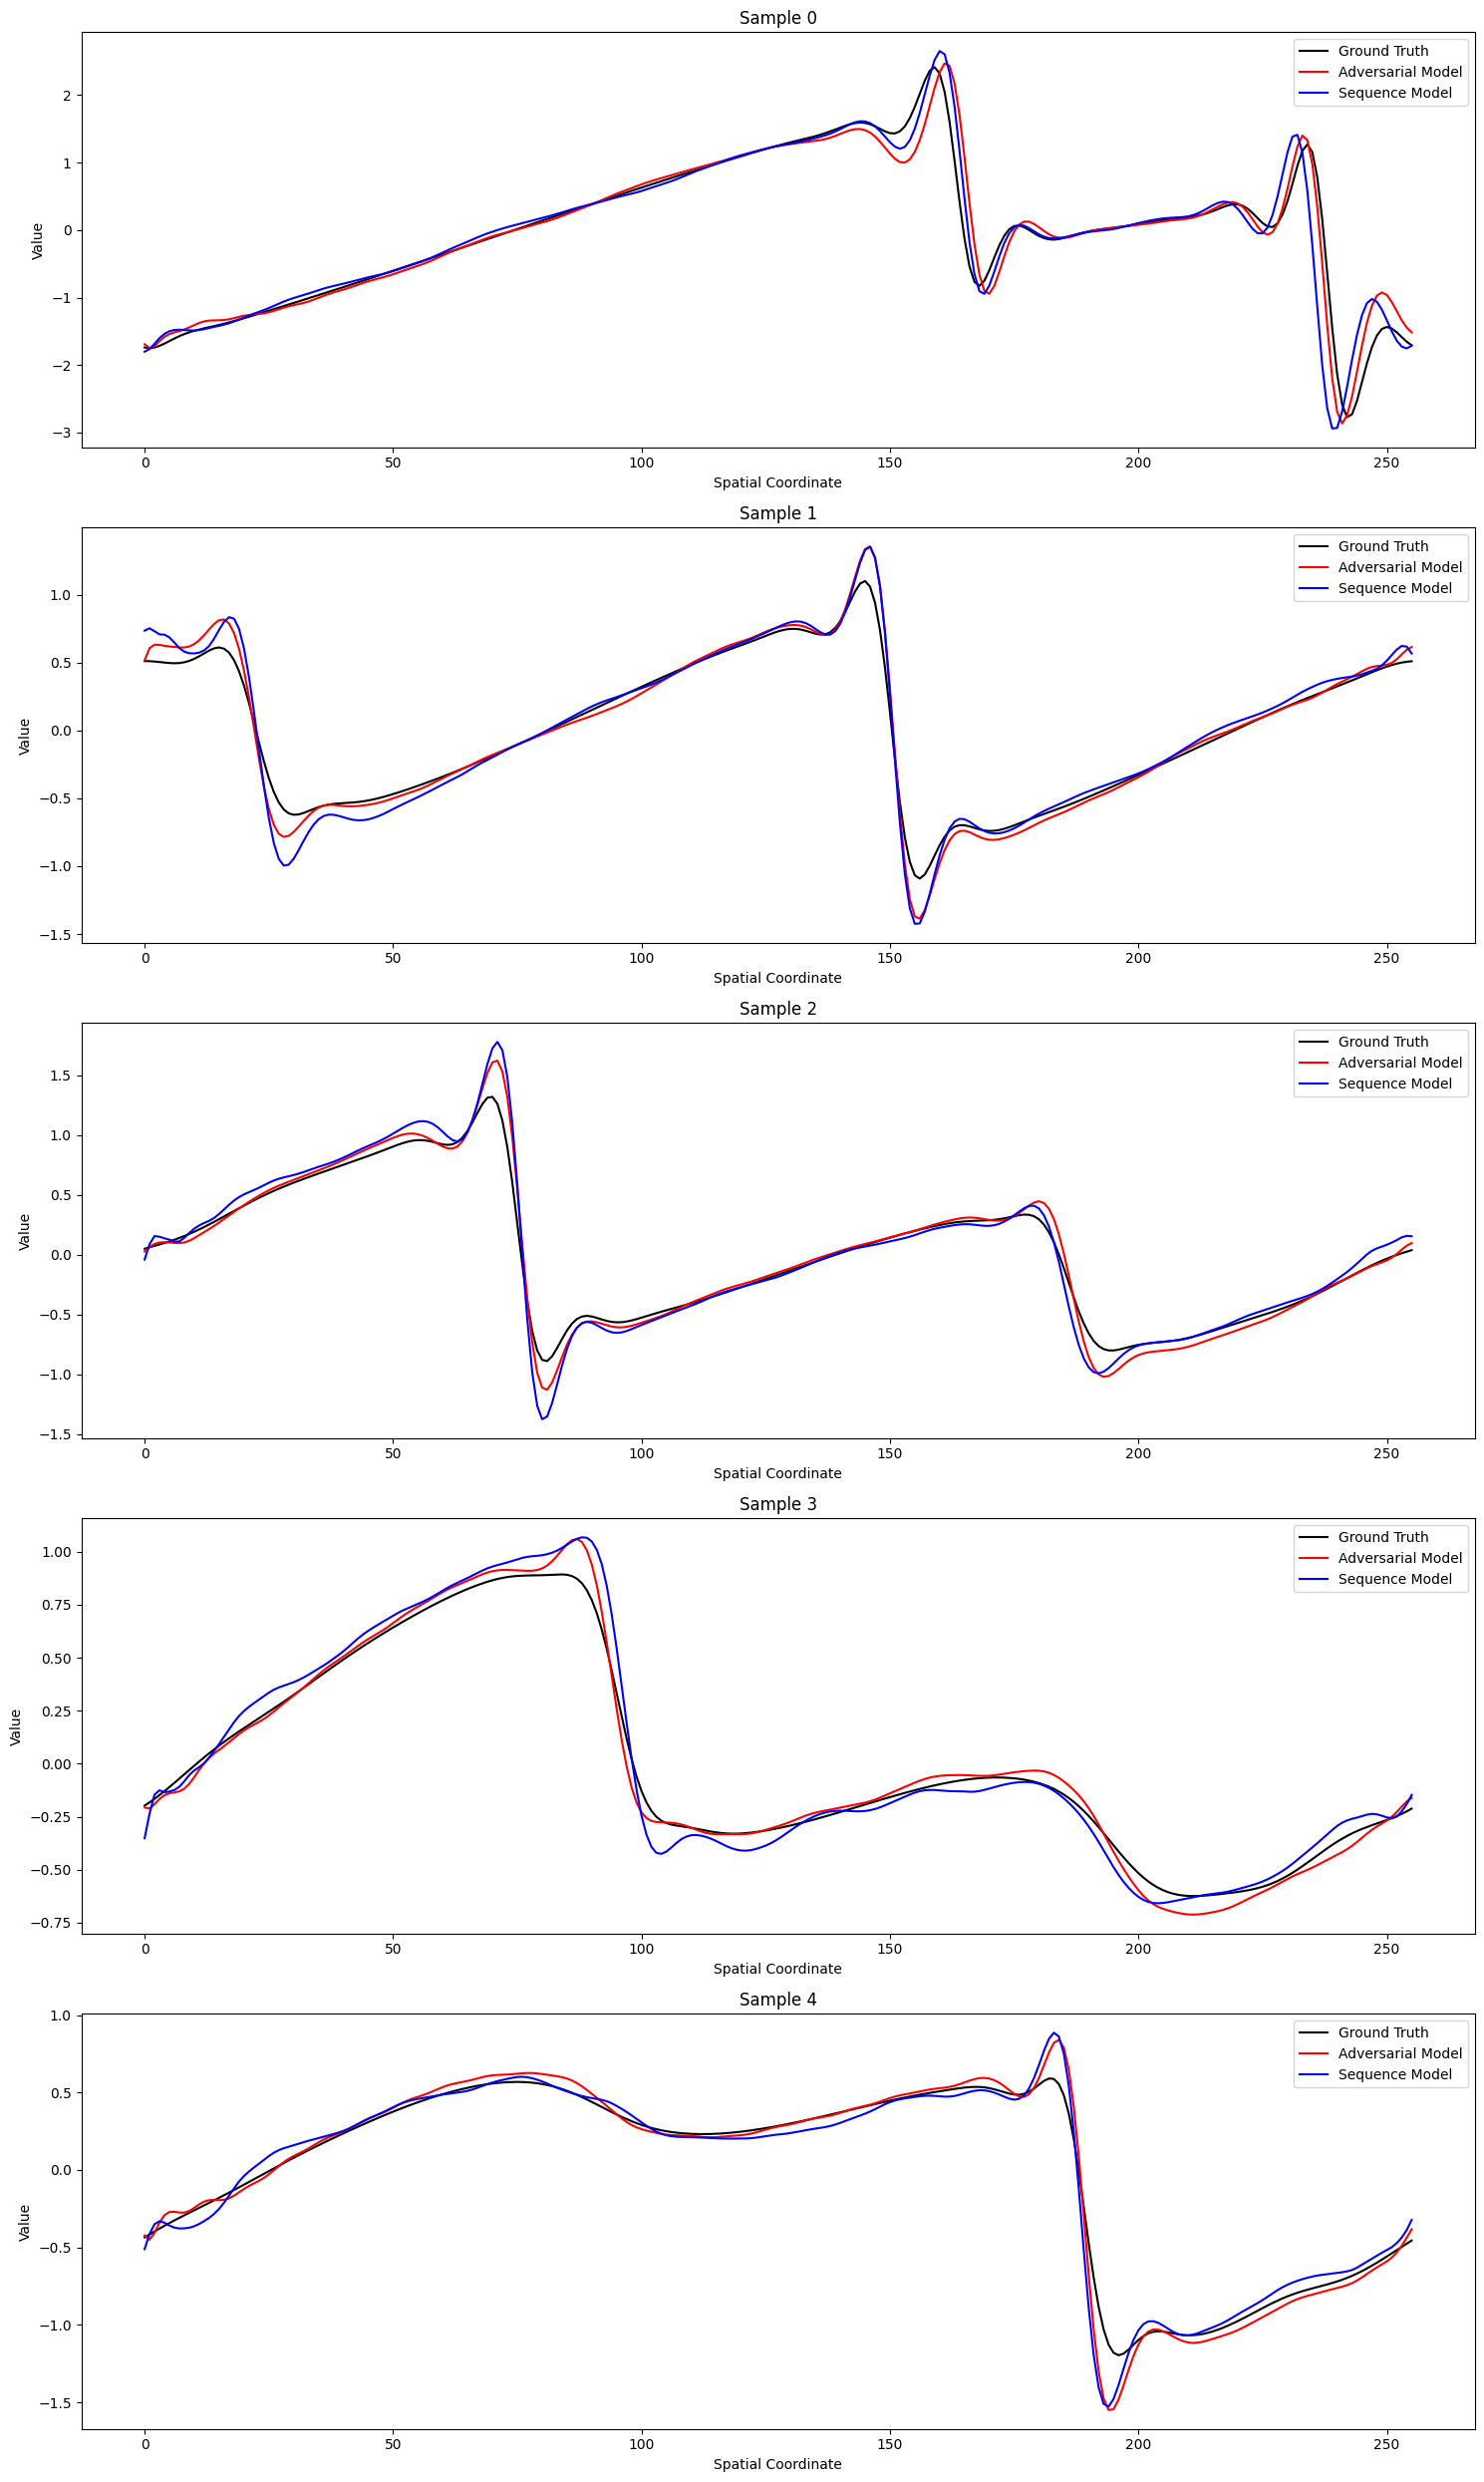

In [76]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

time_steps_to_predict = 200

test_initial_conditions_tensor = torch.tensor(test_initial_conditions, dtype=torch.float32)
test_solutions_tensor = torch.tensor(test_solutions[:, time_steps_to_predict-1, :], dtype=torch.float32)

test_dataset = TensorDataset(test_initial_conditions_tensor, test_solutions_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def predict_with_model(model_path):
    model = FNO1d(modes=32, width=64, input_channels=2, output_channels=20).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_predictions = []
    all_targets = []
    all_inputs = []
    all_pred = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            grid = torch.linspace(0, L, inputs.shape[1]).unsqueeze(0).unsqueeze(-1).to(device)
            inputs = torch.cat((inputs.unsqueeze(-1), grid.expand_as(inputs.unsqueeze(-1))), dim=-1)

            predictions = []
            current_input = inputs
            
            while len(predictions) * 20 < time_steps_to_predict:
                outputs = model(current_input)
                outputs = outputs.squeeze().cpu().numpy()
                predictions.append(outputs)
                last_output = outputs[-1]
                last_output_tensor = torch.tensor(last_output, dtype=torch.float32).to(device)
                last_output_tensor = last_output_tensor.unsqueeze(0).unsqueeze(-1) 
                current_input = torch.cat((last_output_tensor, grid.expand_as(last_output_tensor)), dim=-1)

            predictions = np.concatenate(predictions, axis=0)[:time_steps_to_predict]
            targets = targets.squeeze().cpu().numpy()
            inputs = inputs.squeeze().cpu().numpy()
            all_inputs.append(inputs)
            all_predictions.append(predictions[-1])
            all_targets.append(targets)
            all_pred.append(predictions)

    return np.array(all_predictions), np.array(all_targets), np.array(all_pred)

# Make predictions with both models
predictions_adversarial, targets, pred_adversarial = predict_with_model('best_fno_model_adversarial.pth')
predictions_sequence, _, pred_sequence = predict_with_model('fno_model_sequence.pth')


plt.figure(figsize=(15, 5 * num_samples))

for idx in range(num_samples):
    plt.subplot(num_samples, 1, idx + 1)
    plt.plot(targets[idx], label="Ground Truth", color='black')
    plt.plot(predictions_adversarial[idx], label="Adversarial Model", color='red')
    plt.plot(predictions_sequence[idx], label="Sequence Model", color='blue')
    plt.title(f"Sample {idx}")
    plt.xlabel("Spatial Coordinate")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.show()



C:\Users\FisherMoon25\AppData\Local\Temp\ipykernel_18596\1378280198.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Adversarial - Predictions shape: (10, 2000, 256)
Adversarial - Targets shape: (10, 2000, 256)


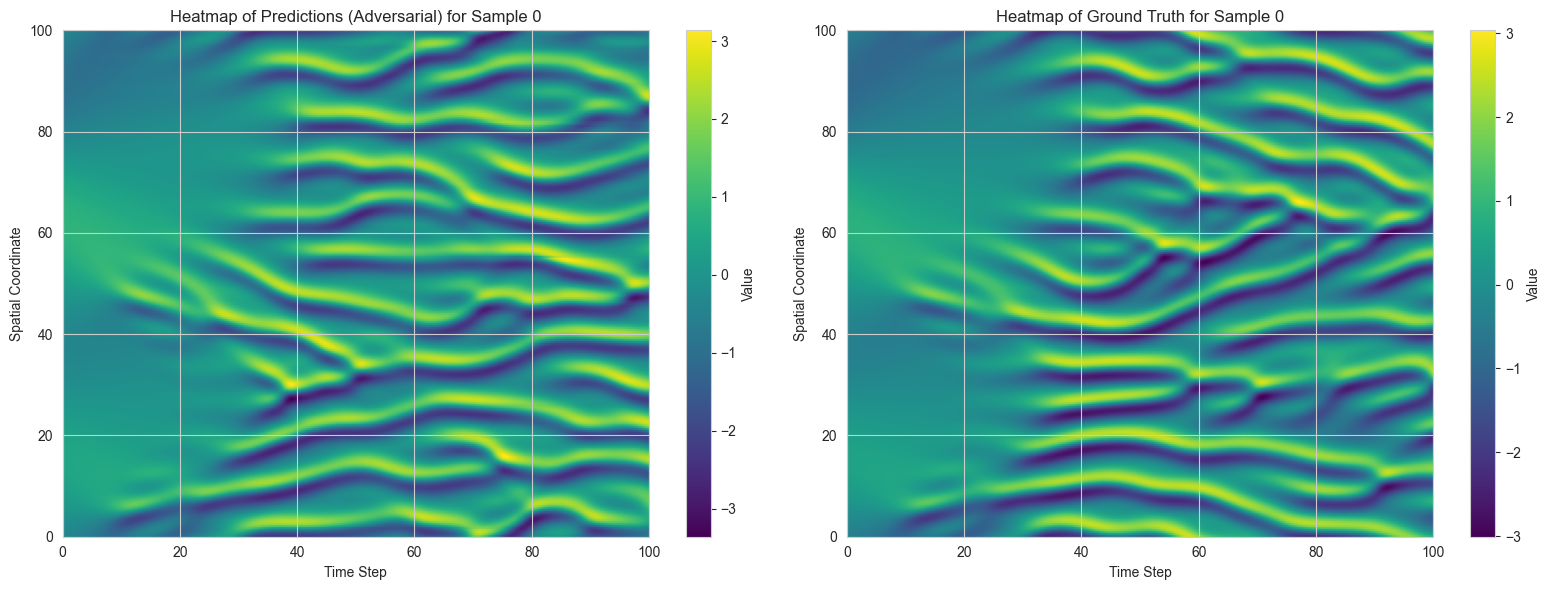

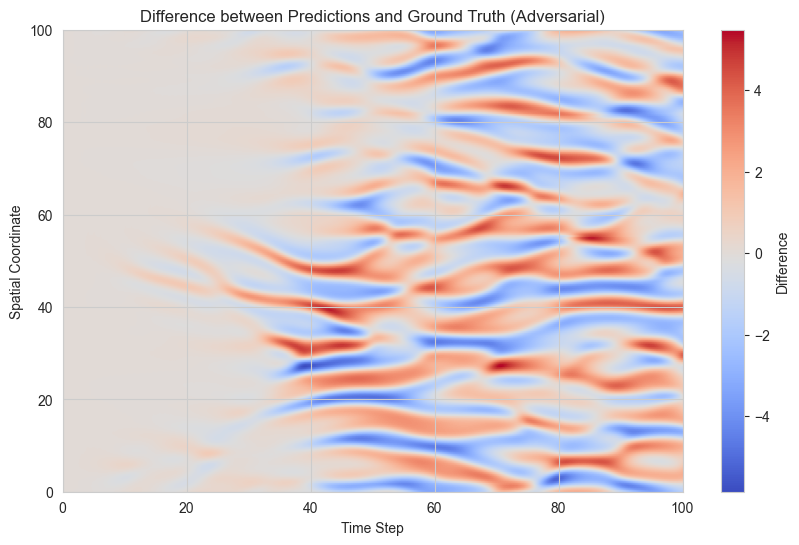

Sequence - Predictions shape: (10, 2000, 256)
Sequence - Targets shape: (10, 2000, 256)


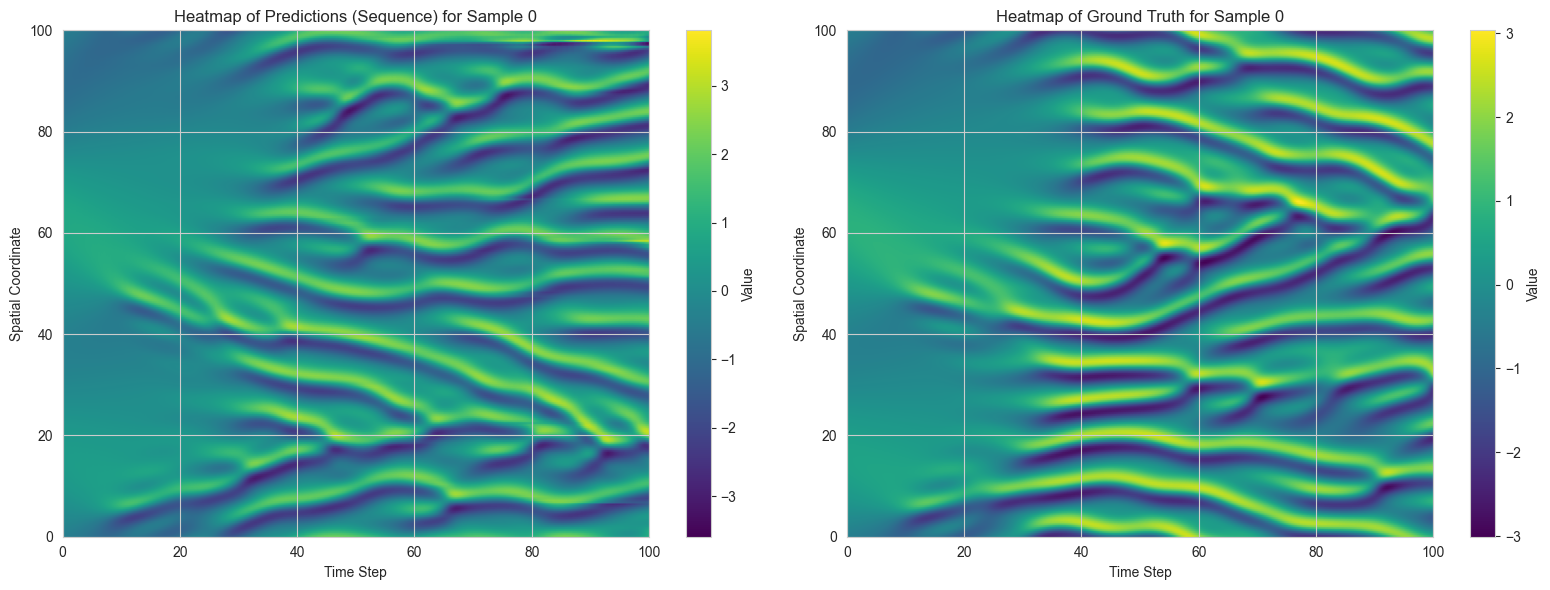

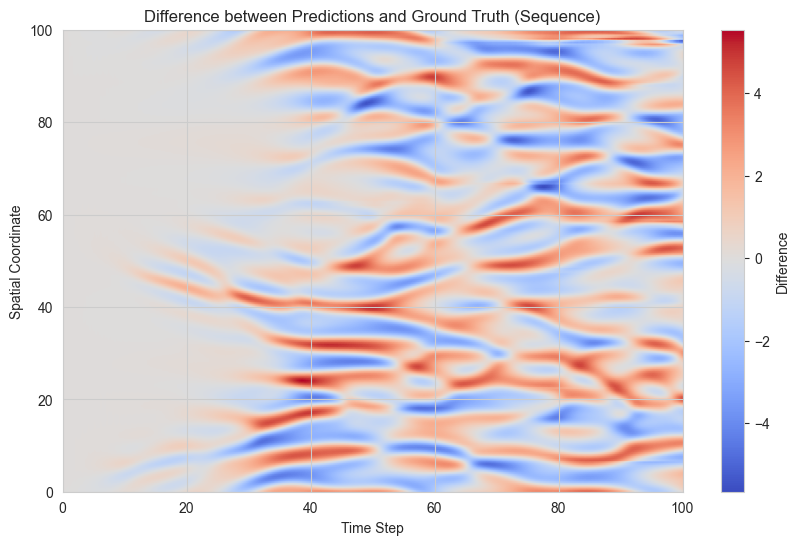

In [83]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

def plot_heatmaps(predictions, targets, idx, model_name, time_steps, L):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot predictions
    ax = axes[0]
    cax = ax.imshow(predictions.T, aspect='auto', cmap='viridis',
                    extent=[0, 0.05*time_steps, 0, L])
    ax.set_title(f"Heatmap of Predictions ({model_name}) for Sample {idx}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Spatial Coordinate")
    fig.colorbar(cax, ax=ax, label='Value')

    # Plot ground truth
    ax = axes[1]
    cax = ax.imshow(targets.T, aspect='auto', cmap='viridis',
                    extent=[0, 0.05*time_steps, 0, L])
    ax.set_title(f"Heatmap of Ground Truth for Sample {idx}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Spatial Coordinate")
    fig.colorbar(cax, ax=ax, label='Value')

    plt.tight_layout()
    plt.savefig(f"{model_name}_heatmap_sample_{idx}.png", dpi=300, bbox_inches='tight')
    plt.show()

def predict_with_model(model_path, test_loader, time_steps, device):
    model = FNO1d(modes=32, width=64, input_channels=2, output_channels=20).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            grid = torch.linspace(0, L, inputs.shape[1]).unsqueeze(0).unsqueeze(-1).to(device)
            inputs = torch.cat((inputs.unsqueeze(-1), grid.expand_as(inputs.unsqueeze(-1))), dim=-1)

            predictions = []
            current_input = inputs
            
            while len(predictions) * 20 < time_steps:
                outputs = model(current_input)
                outputs = outputs.squeeze().cpu().numpy()
                predictions.append(outputs)
                last_output = outputs[-1]
                last_output_tensor = torch.tensor(last_output, dtype=torch.float32).to(device)
                last_output_tensor = last_output_tensor.unsqueeze(0).unsqueeze(-1) 
                current_input = torch.cat((last_output_tensor, grid.expand_as(last_output_tensor)), dim=-1)

            predictions = np.concatenate(predictions, axis=0)[:time_steps]
            targets = targets.squeeze().cpu().numpy()
            all_predictions.append(predictions)
            all_targets.append(targets)

    return np.array(all_predictions), np.array(all_targets)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
L = 100 
time_steps = 2000  

test_initial_conditions_tensor = torch.tensor(test_initial_conditions, dtype=torch.float32)
test_solutions_tensor = torch.tensor(test_solutions[:, :time_steps, :], dtype=torch.float32)
test_dataset = TensorDataset(test_initial_conditions_tensor, test_solutions_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Évaluez les modèles
models = {
    "Adversarial": 'best_fno_model_adversarial.pth',
    "Sequence": 'fno_model_sequence.pth'
}

for model_name, model_path in models.items():
    predictions, targets = predict_with_model(model_path, test_loader, time_steps, device)
    
    print(f"{model_name} - Predictions shape:", predictions.shape)
    print(f"{model_name} - Targets shape:", targets.shape)

    plot_heatmaps(predictions[0], targets[0], 0, model_name, time_steps, L)

    difference = predictions - targets
    plt.figure(figsize=(10, 6))
    plt.imshow(difference[0].T, aspect='auto', cmap='coolwarm', 
               extent=[0, 0.05*time_steps, 0, L])
    plt.title(f"Difference between Predictions and Ground Truth ({model_name})")
    plt.xlabel("Time Step")
    plt.ylabel("Spatial Coordinate")
    plt.colorbar(label='Difference')
    plt.savefig(f"{model_name}_difference_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    
    np.save(f"{model_name}_predictions.npy", predictions)
    np.save(f"{model_name}_targets.npy", targets)

   


Analyzing correlations for Adversarial Model
Predictions shape: (10, 2000, 256)
References shape: (10, 2000, 256)


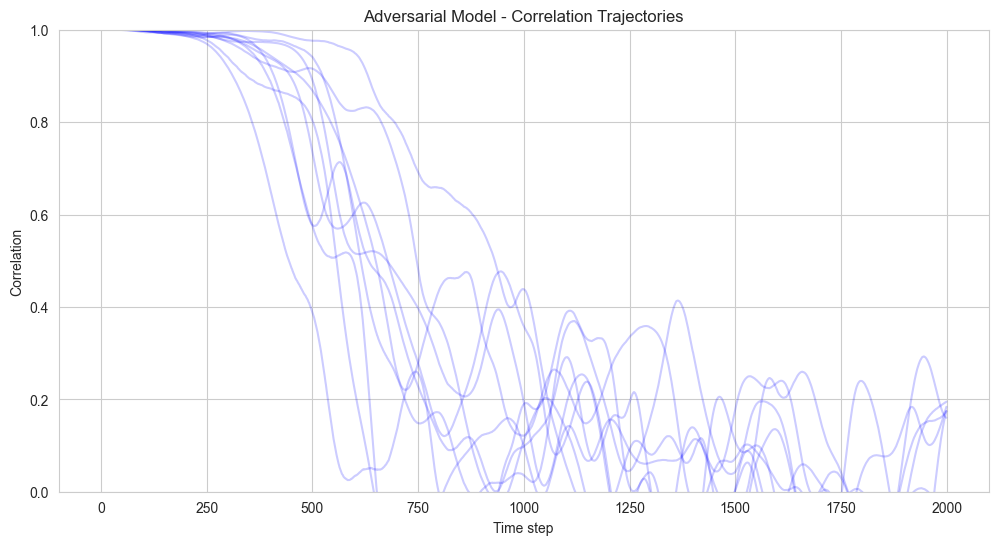

Mean correlation: 0.3204

Analyzing correlations for Sequence Model
Predictions shape: (10, 2000, 256)
References shape: (10, 2000, 256)


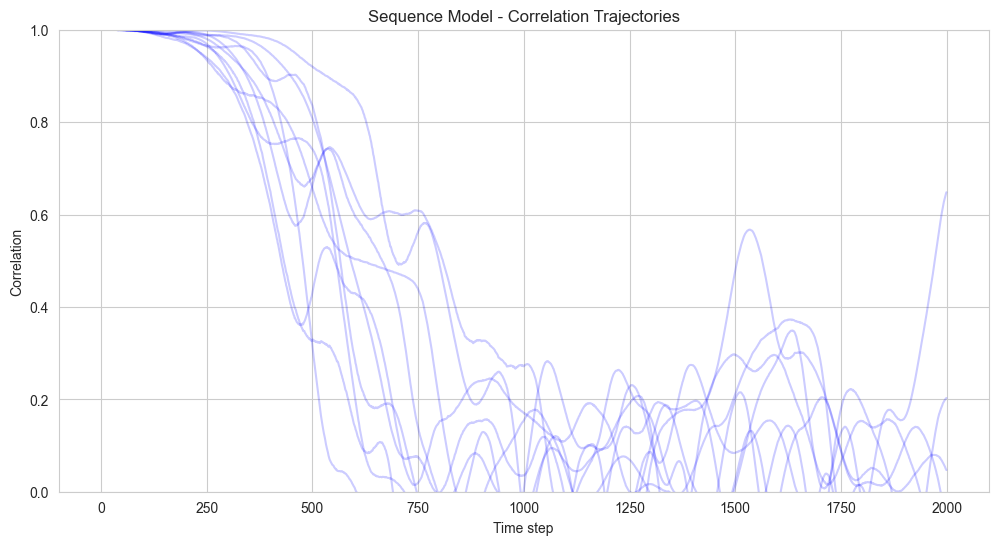

Mean correlation: 0.2926


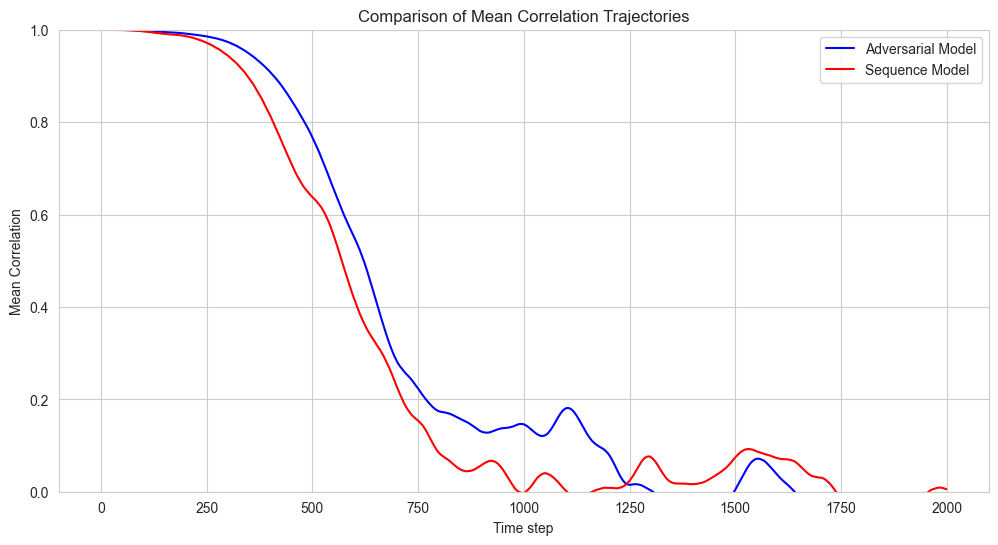

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

def correlation(pred, ref):
    pred_normalized = pred / np.linalg.norm(pred)
    ref_normalized = ref / np.linalg.norm(ref)
    return np.dot(pred_normalized.flatten(), ref_normalized.flatten())

def compute_correlation_trajectories(predictions, references):
    corr_trajectories = np.zeros((predictions.shape[0], predictions.shape[1]))
    for i in range(predictions.shape[0]):
        for j in range(predictions.shape[1]):
            corr_trajectories[i, j] = correlation(predictions[i, j], references[i, j])
    return corr_trajectories

def plot_correlation_trajectories(corr_trajectories, title):
    plt.figure(figsize=(12, 6))
    plt.plot(corr_trajectories.T, alpha=0.2, color='blue')
    plt.ylim(0, 1)
    plt.title(f"{title} - Correlation Trajectories")
    plt.xlabel("Time step")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.savefig(f"{title.lower().replace(' ', '_')}_correlation_trajectories.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_mean_correlation_trajectory(corr_trajectories, title):
    mean_corr_trj = np.mean(corr_trajectories, axis=0)
    std_corr_trj = np.std(corr_trajectories, axis=0)
    sem_corr_trj = sem(corr_trajectories, axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(mean_corr_trj, color='red', linewidth=2, label='Mean')
    plt.fill_between(range(len(mean_corr_trj)), 
                     mean_corr_trj - std_corr_trj, 
                     mean_corr_trj + std_corr_trj, 
                     alpha=0.3, color='red', label='±1 Std Dev')
    plt.fill_between(range(len(mean_corr_trj)), 
                     mean_corr_trj - sem_corr_trj, 
                     mean_corr_trj + sem_corr_trj, 
                     alpha=0.5, color='red', label='±1 SEM')
    plt.ylim(0, 1)
    plt.title(f"{title} - Mean Correlation Trajectory")
    plt.xlabel("Time step")
    plt.ylabel("Mean Correlation")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{title.lower().replace(' ', '_')}_mean_correlation_trajectory.png", dpi=300, bbox_inches='tight')
    plt.show()

def analyze_correlations(predictions, references, title):
    print(f"\nAnalyzing correlations for {title}")
    print(f"Predictions shape: {predictions.shape}")
    print(f"References shape: {references.shape}")

    corr_trajectories = compute_correlation_trajectories(predictions, references)
    
    plot_correlation_trajectories(corr_trajectories, title)
    #plot_mean_correlation_trajectory(corr_trajectories, title)

    mean_corr = np.mean(corr_trajectories)
  
    print(f"Mean correlation: {mean_corr:.4f}")
    
   
   
    return corr_trajectories


adversarial_predictions = np.load("Adversarial_predictions.npy")
adversarial_targets = np.load("Adversarial_targets.npy")
sequence_predictions = np.load("Sequence_predictions.npy")
sequence_targets = np.load("Sequence_targets.npy")

# Analyse pour le modèle adversarial
adversarial_corr = analyze_correlations(adversarial_predictions, adversarial_targets, "Adversarial Model")

# Analyse pour le modèle de séquence
sequence_corr = analyze_correlations(sequence_predictions, sequence_targets, "Sequence Model")

# Comparer les deux modèles
plt.figure(figsize=(12, 6))
plt.plot(np.mean(adversarial_corr, axis=0), label='Adversarial Model', color='blue')
plt.plot(np.mean(sequence_corr, axis=0), label='Sequence Model', color='red')
plt.ylim(0, 1)
plt.title("Comparison of Mean Correlation Trajectories")
plt.xlabel("Time step")
plt.ylabel("Mean Correlation")
plt.legend()
plt.grid(True)
plt.savefig("comparison_correlation_trajectories.png", dpi=300, bbox_inches='tight')
plt.show()